# Fuzzy Tips In Restarunts Estimator

# Inputs - 2, (i) QoService, (ii) QoFOOD - > Quality measured from 0 to 10
# Outputs - 1 , %age of tip gets added to the bill amount in the range 0 to 25

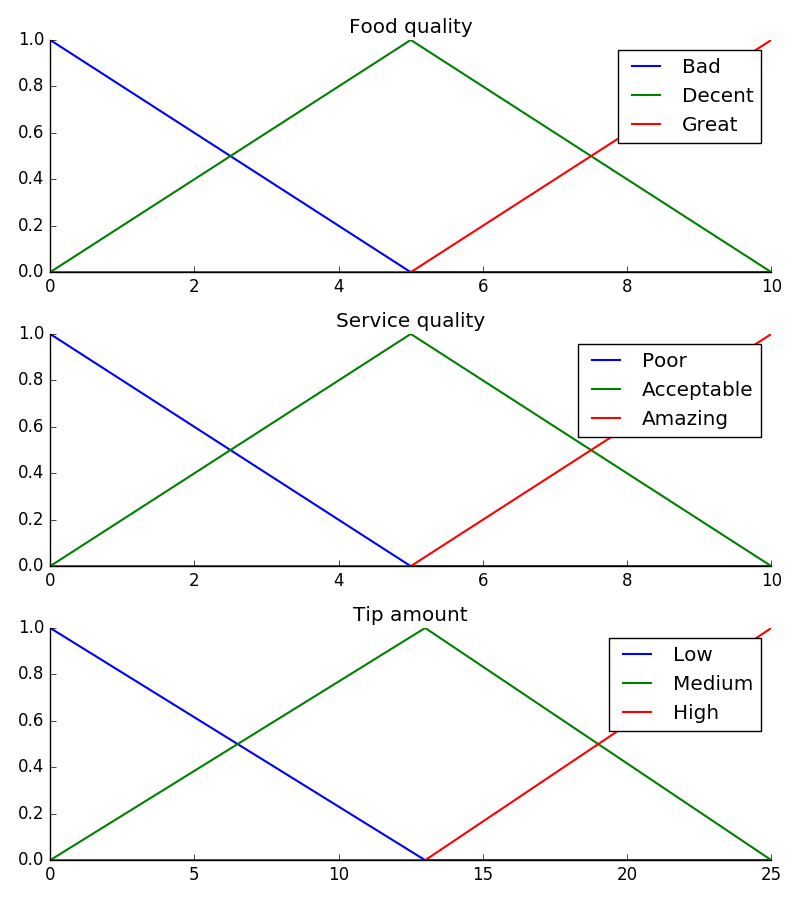

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

In [2]:
x_qual = np.arange(0, 11, 1)
x_serv = np.arange(0, 11, 1)
x_tip  = np.arange(0, 26, 1)

In [4]:
print(x_qual)

[ 0  1  2  3  4  5  6  7  8  9 10]


# Fuzzify the Input Crisp Variables
# 1. Fuzzification 

# Define Membership Functions

In [5]:
qual_lo = fuzz.trimf(x_qual, [0, 0, 5])
qual_md = fuzz.trimf(x_qual, [0, 5, 10])
qual_hi = fuzz.trimf(x_qual, [5, 10, 10])
serv_lo = fuzz.trimf(x_serv, [0, 0, 5])
serv_md = fuzz.trimf(x_serv, [0, 5, 10])
serv_hi = fuzz.trimf(x_serv, [5, 10, 10])
tip_lo = fuzz.trimf(x_tip, [0, 0, 13])
tip_md = fuzz.trimf(x_tip, [0, 13, 25])
tip_hi = fuzz.trimf(x_tip, [13, 25, 25])

# Visualize these universes and membership functions

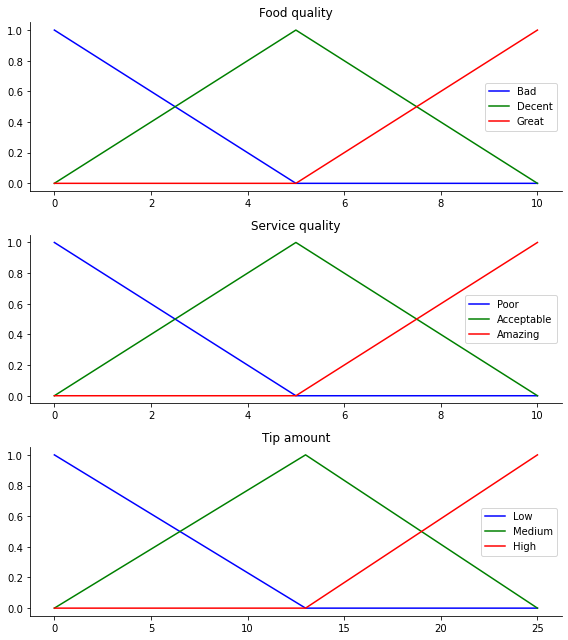

In [6]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

ax0.plot(x_qual, qual_lo, 'b', linewidth=1.5, label='Bad')
ax0.plot(x_qual, qual_md, 'g', linewidth=1.5, label='Decent')
ax0.plot(x_qual, qual_hi, 'r', linewidth=1.5, label='Great')
ax0.set_title('Food quality')
ax0.legend()

ax1.plot(x_serv, serv_lo, 'b', linewidth=1.5, label='Poor')
ax1.plot(x_serv, serv_md, 'g', linewidth=1.5, label='Acceptable')
ax1.plot(x_serv, serv_hi, 'r', linewidth=1.5, label='Amazing')
ax1.set_title('Service quality')
ax1.legend()

ax2.plot(x_tip, tip_lo, 'b', linewidth=1.5, label='Low')
ax2.plot(x_tip, tip_md, 'g', linewidth=1.5, label='Medium')
ax2.plot(x_tip, tip_hi, 'r', linewidth=1.5, label='High')
ax2.set_title('Tip amount')
ax2.legend()
# Turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

# Fuzzy rules
Now, to make these triangles useful, we define the fuzzy relationship between input and output variables. For the purposes of our example, consider three simple rules:

# If the food is bad OR the service is poor, then the tip will be low
# If the service is acceptable, then the tip will be medium
# If the food is great OR the service is amazing, then the tip will be high.

Most people would agree on these rules, but the rules are fuzzy. Mapping the imprecise rules into a defined, actionable tip is a challenge. This is the kind of task at which fuzzy logic excels.

# Rule application

What would the tip be in the following circumstance:

Food quality was 6.5
Service was 9.8

In [7]:
# We need the activation of our fuzzy membership functions at these values.
# The exact values 6.5 and 9.8 do not exist on our universes...
# This is what fuzz.interp_membership exists for!
qual_level_lo = fuzz.interp_membership(x_qual, qual_lo, 6.5)
qual_level_md = fuzz.interp_membership(x_qual, qual_md, 6.5)
qual_level_hi = fuzz.interp_membership(x_qual, qual_hi, 6.5)

serv_level_lo = fuzz.interp_membership(x_serv, serv_lo, 9.8)
serv_level_md = fuzz.interp_membership(x_serv, serv_md, 9.8)
serv_level_hi = fuzz.interp_membership(x_serv, serv_hi, 9.8)

In [9]:
# Now we take our rules and apply them. Rule 1 concerns bad food OR service.
# The OR operator means we take the maximum of these two.
active_rule1 = np.fmax(qual_level_lo, serv_level_lo)

In [10]:
# Now we apply this by clipping the top off the corresponding output
# membership function with `np.fmin`
tip_activation_lo = np.fmin(active_rule1, tip_lo)  # removed entirely to 0

In [11]:
# For rule 2 we connect acceptable service to medium tipping
tip_activation_md = np.fmin(serv_level_md, tip_md)

In [12]:
# For rule 3 we connect high service OR high food with high tipping
active_rule3 = np.fmax(qual_level_hi, serv_level_hi)
tip_activation_hi = np.fmin(active_rule3, tip_hi)
tip0 = np.zeros_like(x_tip)

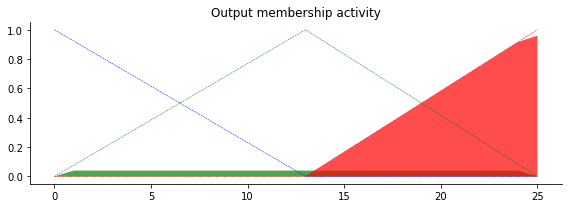

In [13]:
# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.fill_between(x_tip, tip0, tip_activation_lo, facecolor='b', alpha=0.7)
ax0.plot(x_tip, tip_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.fill_between(x_tip, tip0, tip_activation_md, facecolor='g', alpha=0.7)
ax0.plot(x_tip, tip_md, 'g', linewidth=0.5, linestyle='--')
ax0.fill_between(x_tip, tip0, tip_activation_hi, facecolor='r', alpha=0.7)
ax0.plot(x_tip, tip_hi, 'r', linewidth=0.5, linestyle='--')
ax0.set_title('Output membership activity')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

# Rule aggregation
With the activity of each output membership function known, all output membership functions must be combined. This is typically done using a maximum operator. This step is also known as aggregation.

# Defuzzification
Finally, to get a real world answer, we return to crisp logic from the world of fuzzy membership functions. For the purposes of this example the centroid method will be used.

# The result is a tip of 20.2%.¶

In [14]:
# Aggregate all three output membership functions together
aggregated = np.fmax(tip_activation_lo,
                     np.fmax(tip_activation_md, tip_activation_hi))

In [15]:
# Calculate defuzzified result
tip = fuzz.defuzz(x_tip, aggregated, 'centroid')
tip_activation = fuzz.interp_membership(x_tip, aggregated, tip)  # for plot

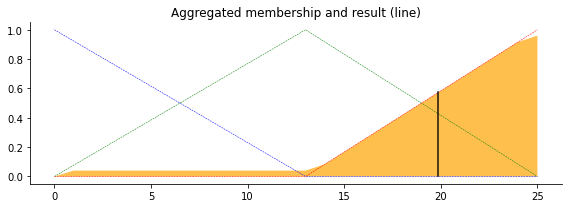

In [16]:
# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.plot(x_tip, tip_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.plot(x_tip, tip_md, 'g', linewidth=0.5, linestyle='--')
ax0.plot(x_tip, tip_hi, 'r', linewidth=0.5, linestyle='--')
ax0.fill_between(x_tip, tip0, aggregated, facecolor='Orange', alpha=0.7)
ax0.plot([tip, tip], [0, tip_activation], 'k', linewidth=1.5, alpha=0.9)
ax0.set_title('Aggregated membership and result (line)')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

In [17]:
tip

19.86871794871795